In [1]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
from ND_north_star.src.edge_detection.contour_points import find_boundary_points, group_distinct_boundary_curves, generate_spline_curve
import ND_north_star.src.edge_detection.gradient_detection as ED_sim


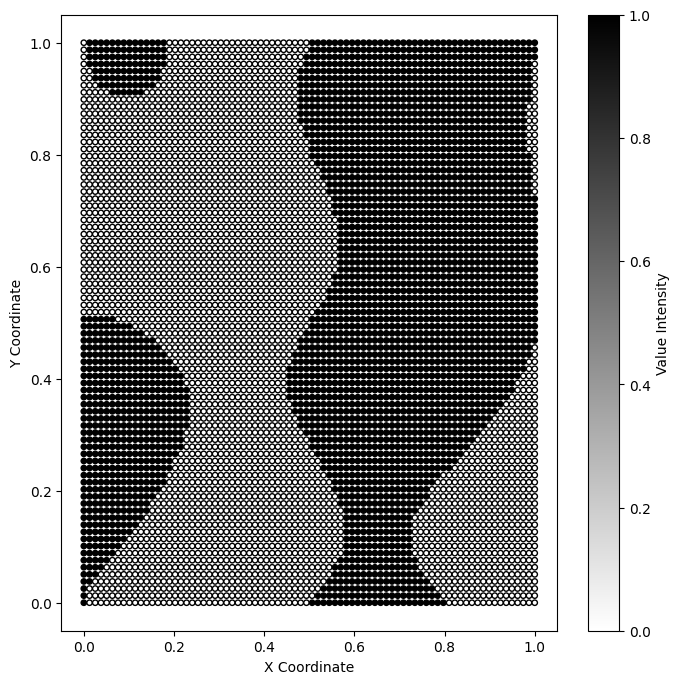

In [2]:
resolution = 80
dimensions = [resolution, resolution]


dataset = PNG.normalized_perlin_data(dimensions, 2)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(dataset, 'black')

In [3]:
boundary_points = find_boundary_points(dataset)
# print(boundary_points)

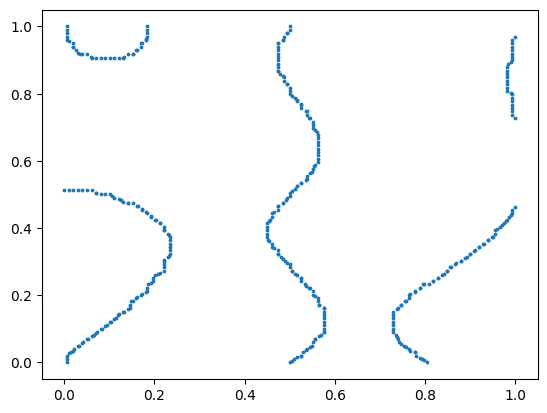

In [4]:
import matplotlib.pyplot as plt

X = boundary_points[:, 0]
Y = boundary_points[:, 1]

plt.scatter(X, Y, s=3)
plt.show()

In [5]:
# from sklearn.cluster import DBSCAN
# import numpy as np

# def distinct_boundary_curves(boundary_points):

#     # Use DBSCAN to find clusters of points
#     dbscan = DBSCAN(eps=0.03, min_samples=3)  # Adjust eps as needed

#     points = boundary_points
#     clusters = dbscan.fit_predict(boundary_points)



#     # Create a dictionary to hold distinct boundaries
#     distinct_boundaries = {}
#     for idx, label in enumerate(clusters):
#         if label not in distinct_boundaries:
#             distinct_boundaries[label] = []
#         distinct_boundaries[label].append(points[idx])

#     # Convert the lists to numpy arrays for easier manipulation later
#     distinct_boundaries = {k: np.array(v) for k, v in distinct_boundaries.items()}

#     return distinct_boundaries



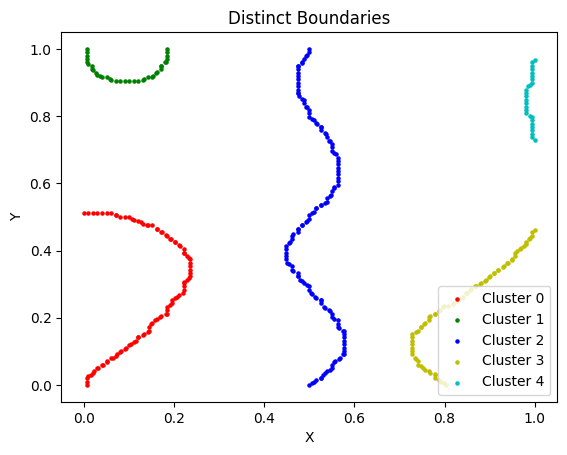

In [6]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        # plt.show()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distinct Boundaries')
plt.legend()
plt.show()

# # Print distinct boundaries
# for label, boundary in distinct_boundaries.items():
#     print(f"Boundary {label}:")
#     print(boundary)

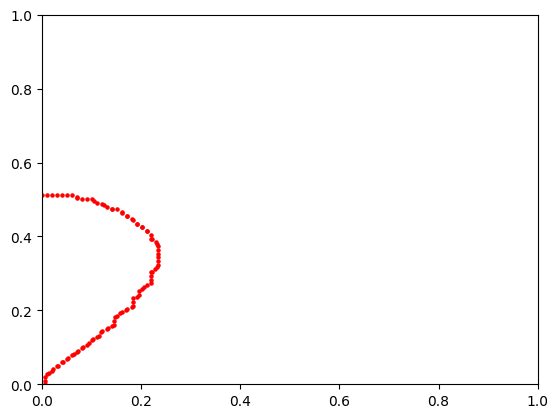

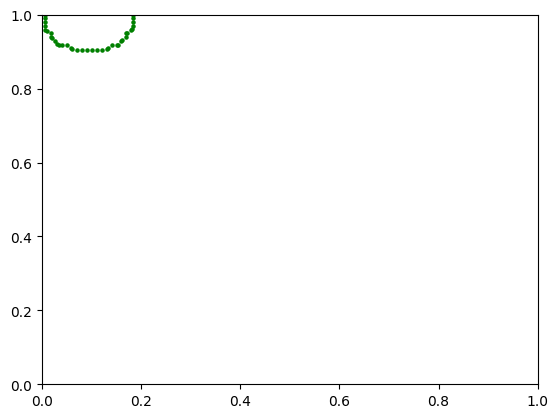

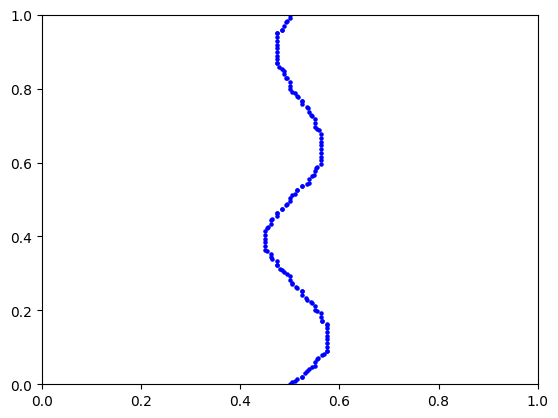

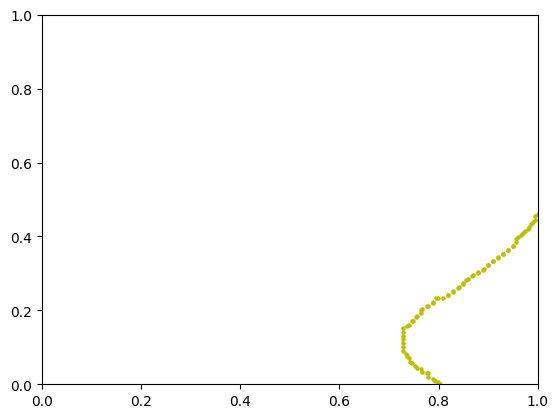

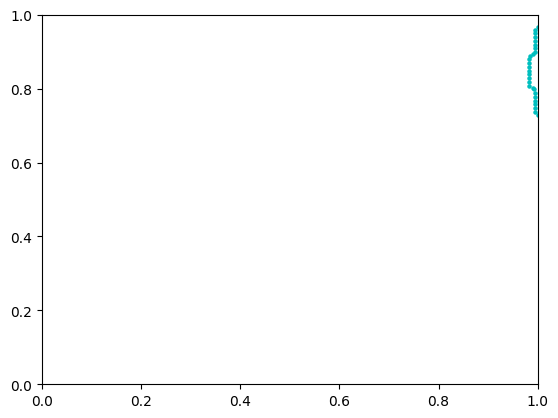

In [7]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Distinct Boundaries')
# plt.legend()
# plt.show()


In [8]:
# print(len(distinct_boundaries))
# print(distinct_boundaries.keys())
# print(distinct_boundaries)


98 98
50 50


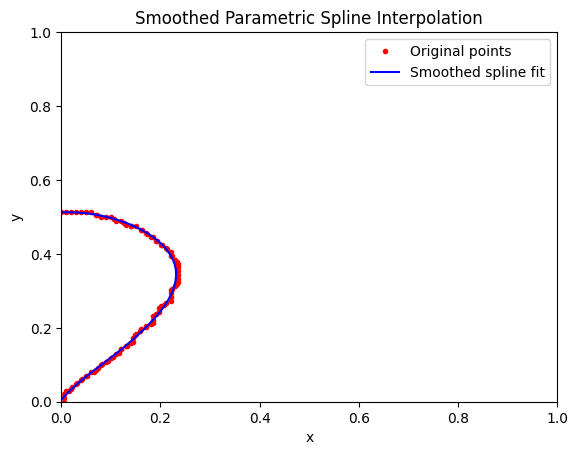

38 38
50 50


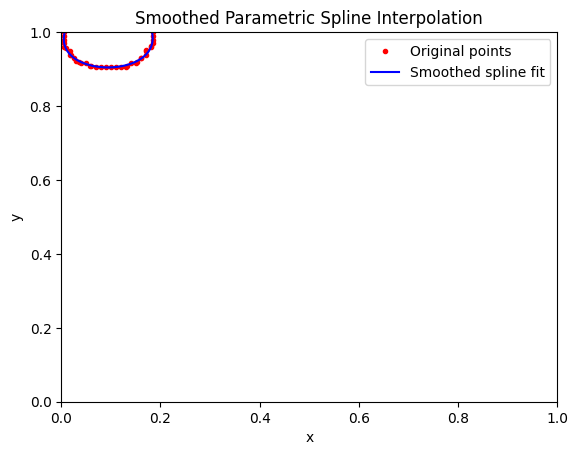

144 144
50 50


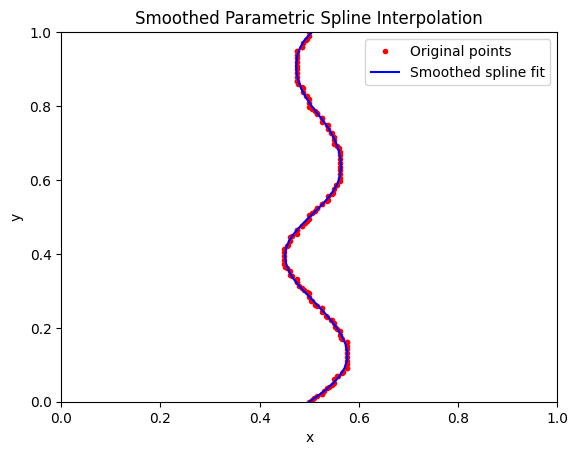

80 80
50 50


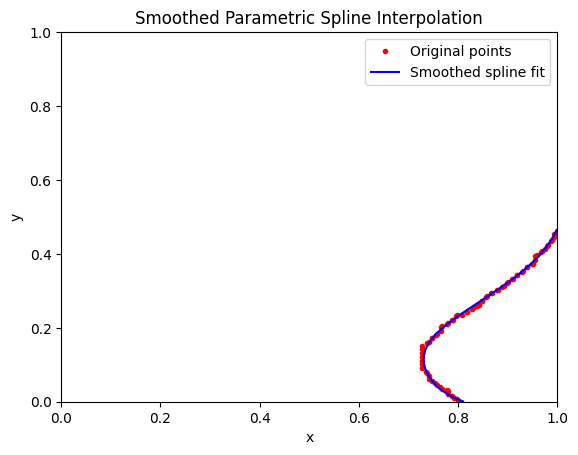

27 27
50 50


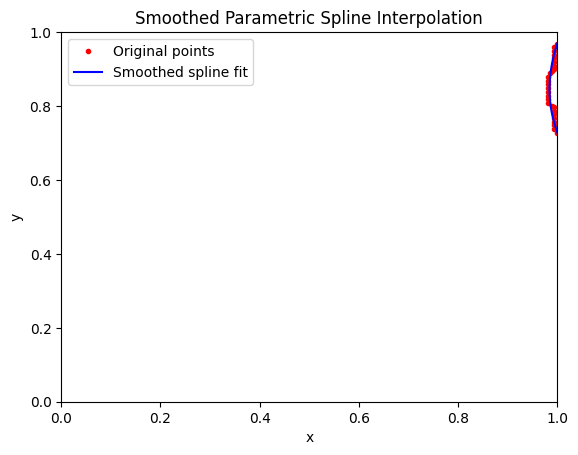

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import splprep, splev



# def generate_spline_curve(points, smoothing_factor=0.001, num_points=100):

#     # Split data into x and y coordinates
#     x = points[:, 0]
#     y = points[:, 1]

#     # Parameterize the points with a parameter t
#     t = np.linspace(0, 1, len(points))

#     # Fit splines to x(t) and y(t) with smoothing factor s
#     # smoothing_factor = .001  # Adjust this value for more or less smoothing
#     tck, u = splprep([x, y], s=smoothing_factor)

#     # Evaluate the spline fit at a dense set of parameter values
#     # num_points = 100  # Number of points in the final smoothed curve
#     x_new, y_new = splev(np.linspace(0, 1, num_points), tck)

#     return x_new, y_new





for ind, points in distinct_boundaries.items():
# # Sample data points
# points = distinct_boundaries[4]  # Adjust this based on your actual data

    x = points[:, 0]
    y = points[:, 1]
    
    x_new, y_new = generate_spline_curve(points, smoothing_factor=0.001, num_points=50)

    print(len(x), len(y))
    print(len(x_new), len(y_new))

    # Plot the original points and the fitted curve
    plt.figure()
    plt.plot(x, y, 'ro', label='Original points', markersize=3)
    plt.plot(x_new, y_new, 'b-', label='Smoothed spline fit')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Smoothed Parametric Spline Interpolation')
    plt.show()